# Desafio – Parte 1: Análise da rede fornecida

Nesta primeira entrega você deve fazer uma análise da rede fornecida. 

Rede disponível no kaggle:
https://www.kaggle.com/t/6c4d1673ebd4409e9e964e7921f53b56

São esperadas visualizações e análises relevantes da rede, com o intuito de proporcionar o
entendimento das principais propriedades da mesma. Além disso, é esperado uma breve discussão
dos principais achados obtidos. Procure entender como alguns dos resultados obtidos poderiam ser
úteis no objetivo final do desafio.

# Alunos
Danilo Gazzoli Resende

Matheus Chaves

# Índice
- [Análise exploratória](#Análise-exploratória)
- [Mapa de Pittsburgh](#Mapa-de-Pittsburgh)
- [Visualização da rede complexa no mapa de Pittsburgh](#Visualização-da-rede-complexa-no-mapa-de-Pittsburgh)
- [Informação da rede](#Informação-da-rede)
- [Grau médio do grafo](#Grau-médio-do-grafo)
- [Distribuição dos graus e componente gigante](#Distribuição-dos-graus-e-componente-gigante)
- [Métricas de centralidade](#Métricas-de-centralidade)
- [Comunidades](#Comunidades)
- [Considerações](#Considerações)

In [ ]:
!pip install osmnx

In [ ]:
!pip install numpy

In [ ]:
!pip install basemap

In [ ]:
!pip install networkx

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
from mpl_toolkits.basemap import Basemap as Basemap
import community.community_louvain as cl

In [51]:
G = nx.read_gml('../data/GraphMissingEdges.gml')

In [52]:
categories_df = pd.read_csv('../data/categories.csv')

In [113]:
long = list(nx.get_node_attributes(G,'longitude').values())
labels = list(G.nodes())
lat = list(nx.get_node_attributes(G,'latitude').values())
categories = list(nx.get_node_attributes(G,'categories').values())
stars = list(nx.get_node_attributes(G,'stars').values())
names = list(nx.get_node_attributes(G,'name').values())
reviewCount = list(nx.get_node_attributes(G,'reviewCount').values())

In [114]:
df = pd.DataFrame({'name': names,
                   'label': labels,
                   'long': long,
                   'lat': lat,
                   'category': categories,
                   'star':stars,
                   'reviewCount': reviewCount})

# Análise exploratória
[top](#Índice)

In [45]:
len(df)

4575

In [46]:
df.head(100)

,name,long,lat,category,star,reviewCount
0,Cafe Fifth Ave,-79.992016,40.438701,"1,362",3.0,20
1,Good Fellas Barber Shop,-80.064789,40.436045,"280,566",4.0,12
2,Tightspot Dancewear Center,-79.979840,40.386165,"327,559,107,63,213",3.0,4
3,Evolve Wellness Spa Shadyside,-79.925404,40.457973,"338,280,247,292,671,546",4.5,95
4,Nova Dental Associates,-80.001983,40.438355,"407,247,270,645,438,488",2.0,5
...,...,...,...,...,...,...
95,Fat Heads Saloon,-79.980176,40.428967,"1,275,604,58",4.0,715
96,City Fresh Pasta,-80.005186,40.451062,"262,1,820,641",4.5,23
97,Schoolhouse Yoga,-79.927154,40.460519,"881,60,102",4.0,4
98,McCullough Tire,-79.795718,40.468191,"867,24",5.0,3


In [47]:
df['reviewCount'].value_counts()

3      462
5      309
4      298
6      233
7      190
      ... 
438      1
433      1
341      1
585      1
300      1
Name: reviewCount, Length: 329, dtype: int64

In [48]:
stars_int = [eval(i) for i in stars]

[Text(0.5, 1.0, 'Estrelas por estabelecimento'),
 Text(0.5, 0, 'Estrelas'),
 Text(0, 0.5, 'frequência')]

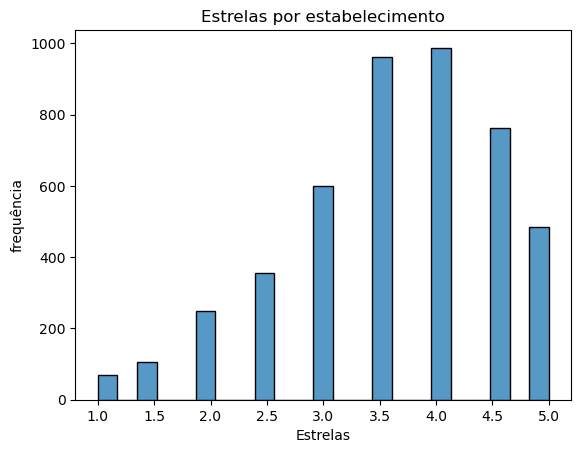

In [37]:
sns.histplot(stars_int).set(title='Estrelas por estabelecimento',xlabel='Estrelas', ylabel='frequência')

/home/s026390869/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

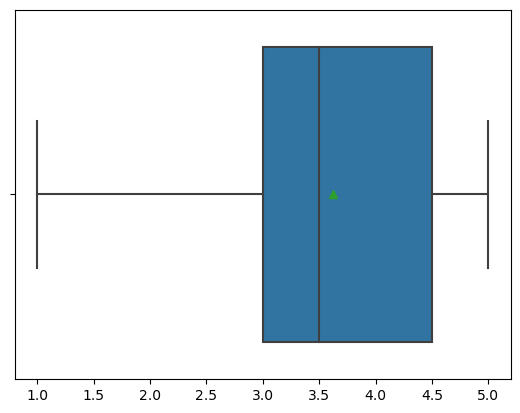

In [14]:
sns.boxplot(stars_int, showmeans=True)

[Text(0.5, 1.0, 'Contagem de reviews'),
 Text(0.5, 0, 'Reviews'),
 Text(0, 0.5, 'frequência')]

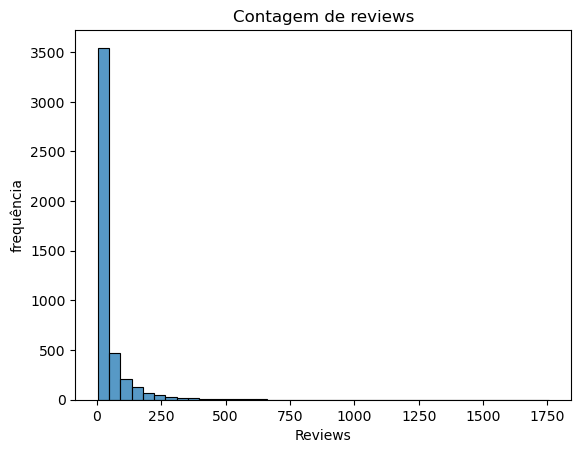

In [36]:
reviewCount_int = [eval(i) for i in reviewCount]
sns.histplot(reviewCount_int, bins=40).set(title='Contagem de reviews',xlabel='Reviews', ylabel='frequência')

/home/s026390869/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

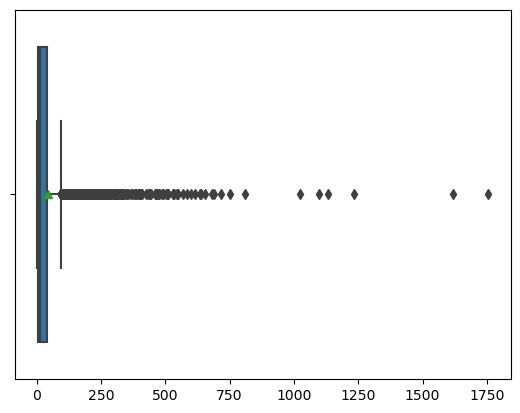

In [16]:
sns.boxplot(reviewCount_int, showmeans=True)

# Mapa de Pittsburgh
[top](#Índice)

/home/s026390869/anaconda3/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(
/home/s026390869/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


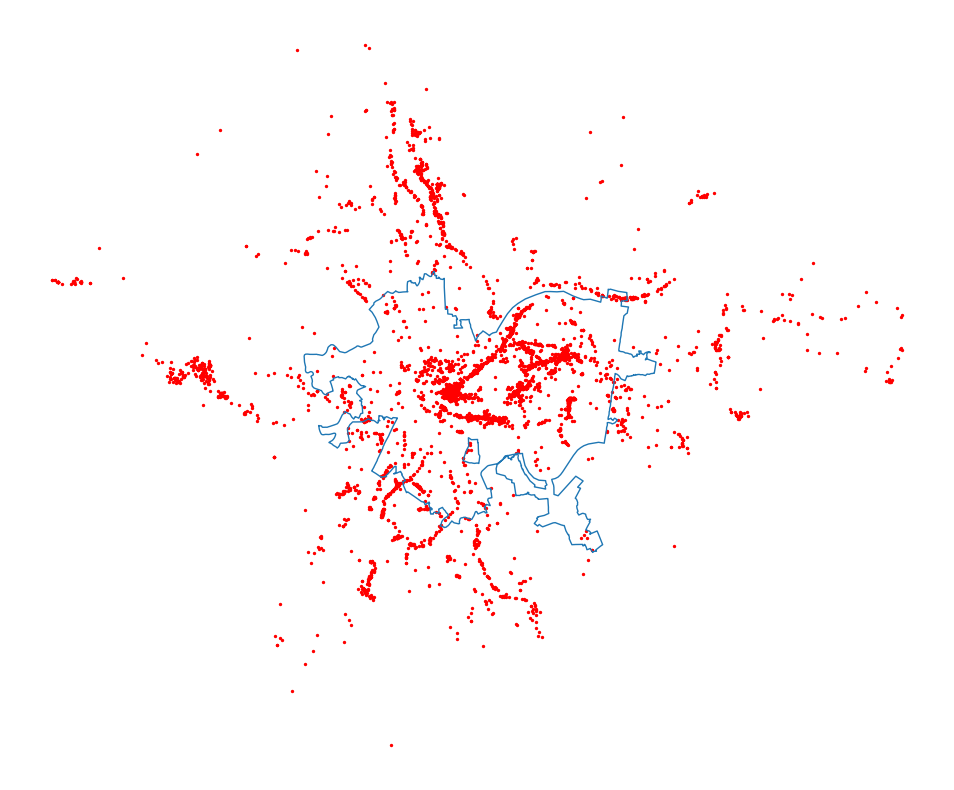

In [17]:
ox.config(use_cache=True, log_console=True)
pittsburgh = ox.geocode_to_gdf("Pittsburgh, United States")

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))
gdf.crs = {'init': 'epsg:4326'} 

pittsburgh = ox.projection.project_gdf(pittsburgh, to_crs='epsg:4326')
ax = pittsburgh.boundary.plot(linewidth=1, figsize=(15, 10))
_ = ax.axis('off')

gdf.plot(ax=ax, color='red', figsize=(15, 10), markersize=2)

plt.show()

# Visualização da rede complexa no mapa de Pittsburgh
[top](#Índice)

In [18]:
coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))

positions = dict(zip(G.nodes, coordinates))


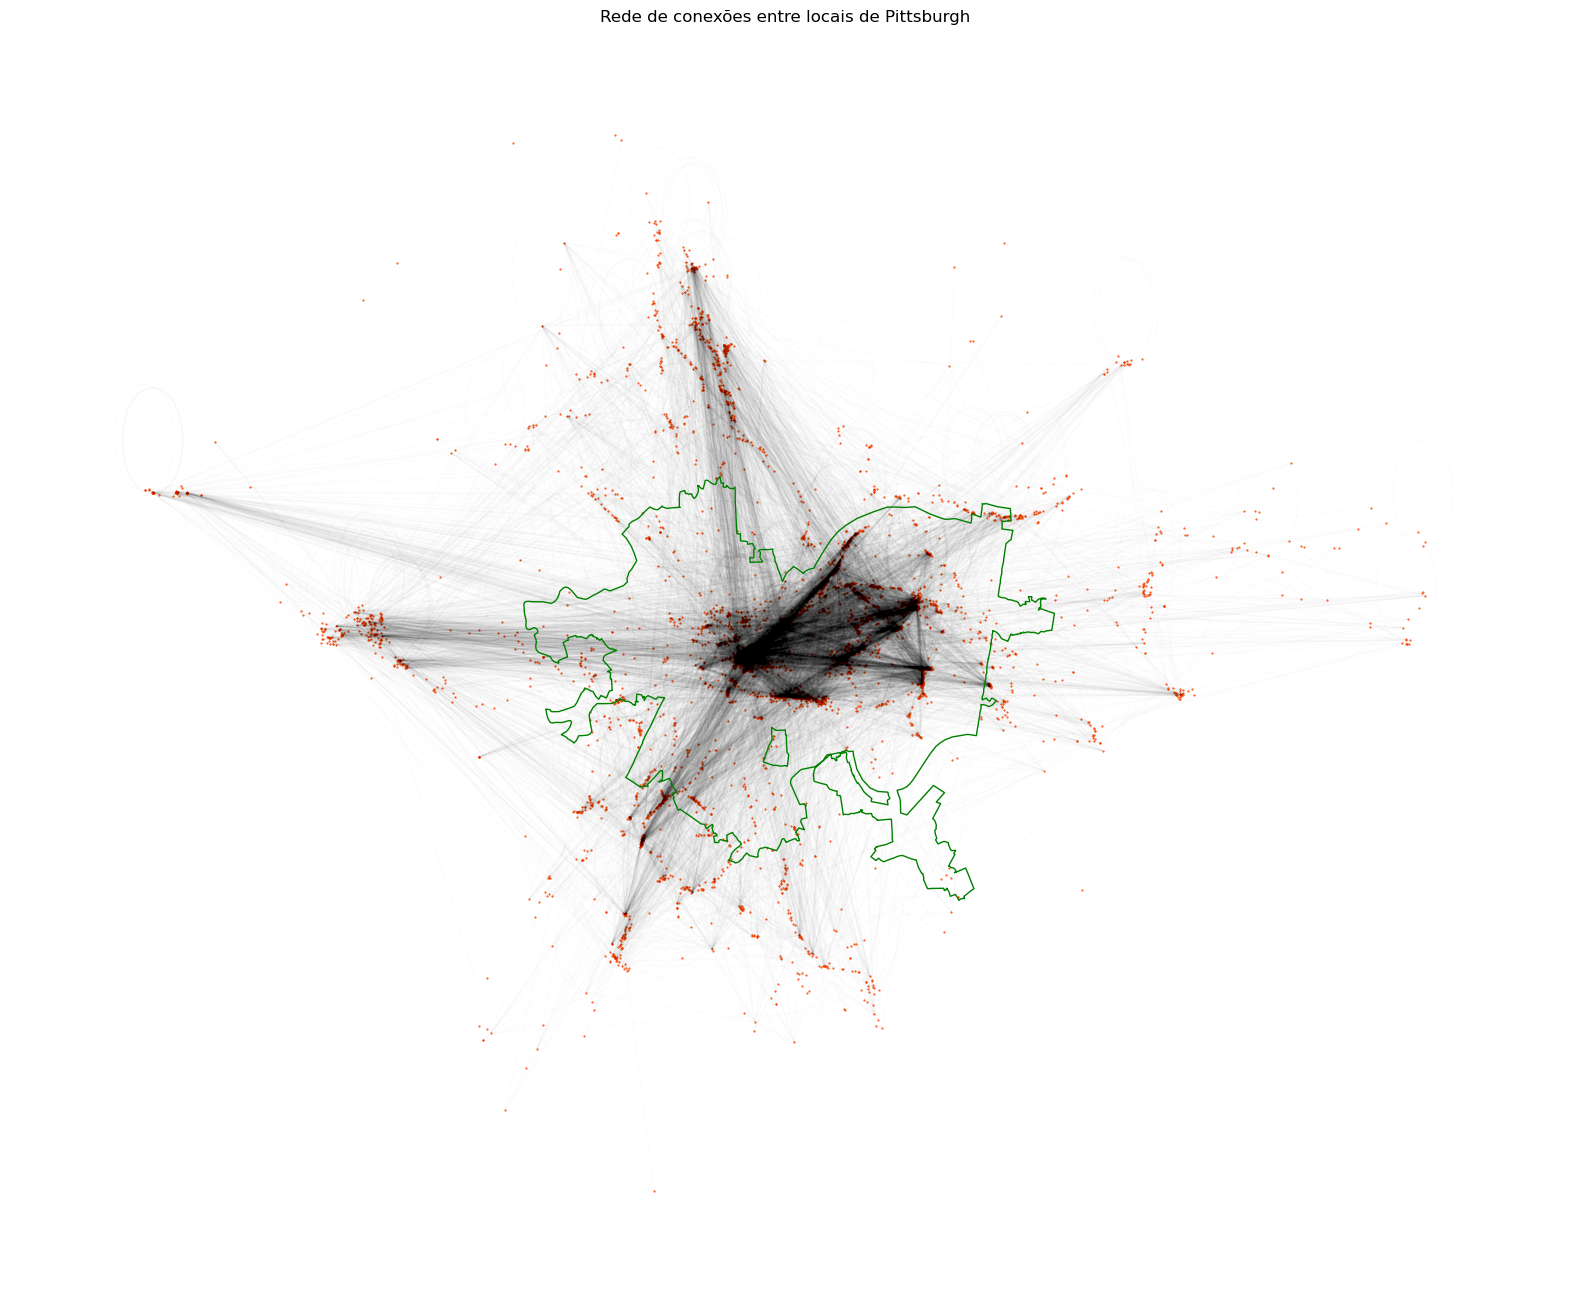

In [19]:
pittsburgh = ox.projection.project_gdf(pittsburgh, to_crs='epsg:4326')

ax = pittsburgh.boundary.plot(color='green', linewidth=1, figsize=(20, 20))
_ = ax.axis('off')

gdf.plot(marker=".", color="orangered", markersize=1, ax=ax)
nx.draw_networkx_edges(G, positions, ax=ax, alpha=0.01, node_size=1.5)
plt.title("Rede de conexões entre locais de Pittsburgh")
plt.show()

________________________________________________________________________________________________________________
# Informação da rede
[top](#Índice)

In [20]:
nos = G.number_of_nodes()
arestas =  G.number_of_edges()
comp_conect = nx.number_connected_components(G)
max_grau = sorted(G.degree, key=lambda x: x[1], reverse=True)[0]
degrees = dict(G.degree())
soma_arestas = sum(degrees.values())
media = soma_arestas/G.number_of_nodes()

print(f'Número de nós: {nos}')
print(f'Número de arestas: {arestas}')
print(f'Número de componentes conectados: {comp_conect}')
print(f'Grau máximo: {max_grau}')
print(f'Grau médio: {media}')
print(f'Densidade do grafo: {nx.density(G)}')
print(f'Average Clustering: {nx.average_clustering(G)}')
#minimum number of nodes that must be removed to disconnect the graph)
print(f'Conectividade: {nx.node_connectivity(G)}')
print(f'O grafo é direcionado?:{nx.is_directed(G)}')

Número de nós: 4575
Número de arestas: 18991
Número de componentes conectados: 756
Grau máximo: ('u4sTiCzVeIHZY8OlaL346Q', 232)
Grau médio: 8.302076502732241
Densidade do grafo: 0.0018150582646987846
Average Clustering: 0.04489358044799767
Conectividade: 0
O grafo é direcionado?:False


# Grau médio do grafo
[top](#Índice)

In [21]:
nodes,links = G.order(), G.size()
avg_deg = float(links)/nodes
print("Grau médio: ", avg_deg)

Grau médio:  4.151038251366121


Obtendo o grau de cada nó, indica o número de nós adjacentes

In [59]:
degree = list(nx.degree(G))
def sort_key(degree):
    return degree[1]

def Convert(tup, di):
    di = dict(tup)
    return di

degrees = {}
degrees = Convert(degree, degrees)

degree.sort(key=sort_key, reverse=True)
for i in range(0,6):
    print(degree[i])

('u4sTiCzVeIHZY8OlaL346Q', 232)
('gldPX9ANF5Nic0N7igu2og', 224)
('dLc1d1zwd1Teu2QED5TmlA', 212)
('woXlprCuowrLJswWere3TQ', 204)
('Voeq7aGDmCGMjE_SQiHwRA', 191)
('MKYcOZSpMwJK7uwacK13EA', 183)


# Distribuição dos graus e componente gigante
[top](#Índice)

Connected Components

For undirected graphs, a component is a maximally connected subgraph, which means that there is at least one path between any two nodes in that subgraph.

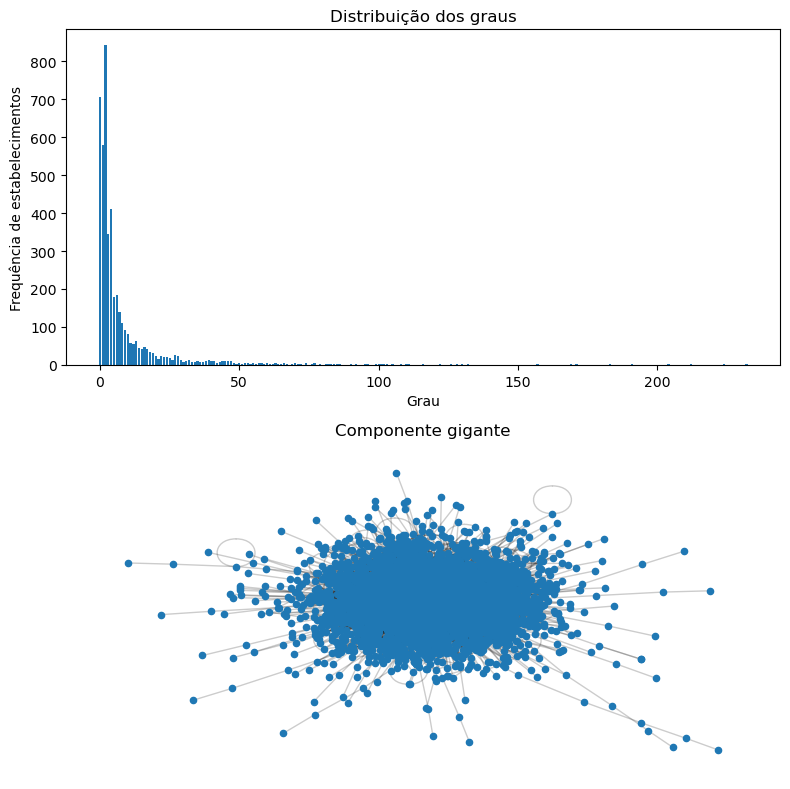

In [70]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

fig = plt.figure("Dados de graus", figsize=(8, 8))
axgrid = fig.add_gridspec(8, 8)
ax = fig.add_subplot(axgrid[0:4, :])
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Distribuição dos graus")
ax.set_xlabel("Grau")
ax.set_ylabel("Frequência de estabelecimentos")

ax0 = fig.add_subplot(axgrid[4:, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=20160)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.2)
ax0.set_title("Componente gigante")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

# Métricas de centralidade
[top](#Índice)

In [55]:
degree_cent = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

In [60]:
nx.set_node_attributes(G, degree, "degree")
nx.set_node_attributes(G, betweenness, "betweenness")
nx.set_node_attributes(G, closeness, "closeness")
nx.set_node_attributes(G, eigenvector, "eigenvector")

Text(0.5, 1.0, 'Mapa de correlação das métricas, stars e reviewcount')

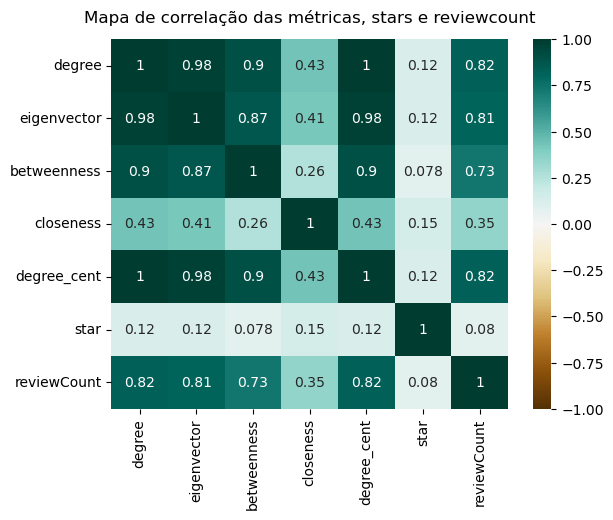

In [28]:
measures = {
    'degree':list(degrees.values()),
    'eigenvector': list(eigenvector.values()),
    'betweenness': list(betweenness.values()),
    'closeness' : list(closeness.values()),
    'degree_cent': list(degree_cent.values()),
    'star':stars_int,
    'reviewCount': reviewCount_int}    

df_measures = pd.DataFrame(measures)
sns.heatmap(df_measures.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG').set_title('Mapa de correlação das métricas, stars e reviewcount', fontdict={'fontsize':12}, pad=12)

# Comunidades
[top](#Índice)

In [77]:
import matplotlib.cm as cm
import statistics

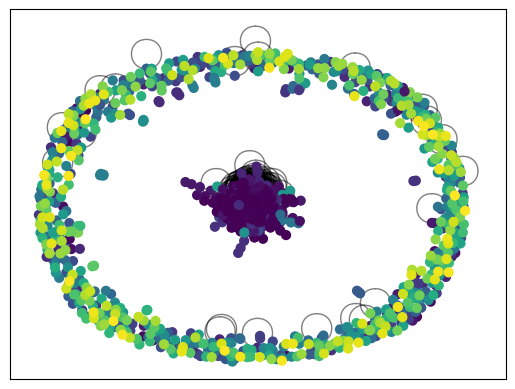

In [68]:
louvain = cl.best_partition(G)
nx.set_node_attributes(G, louvain, "louvain")
pos = nx.spring_layout(G)

# Cores para representar uma comunidade em particular
cmap = cm.get_cmap('viridis', max(louvain.values()) + 1)

nx.draw_networkx_nodes(G, pos, louvain.keys(), node_size=40, cmap=cmap, node_color=list(louvain.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

[Text(0.5, 1.0, 'Distribuição de comunidades'),
 Text(0.5, 0, 'Comunidade'),
 Text(0, 0.5, 'frequência de estabelecimentos na comunidade')]

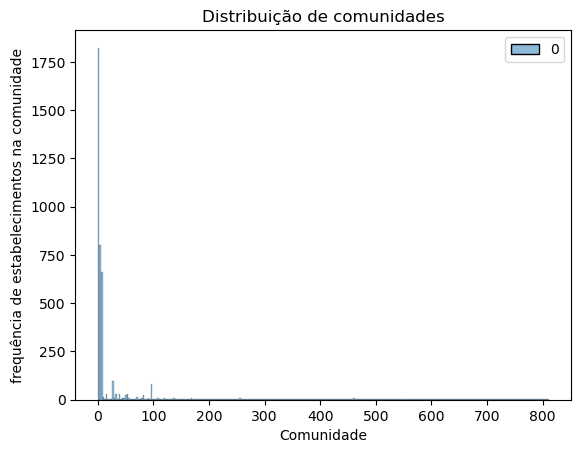

In [205]:
sns.histplot(louvain.values()).set(title='Distribuição de comunidades',xlabel='Comunidade', ylabel='frequência de estabelecimentos na comunidade')

In [201]:
community_count = {}
for venue in louvain.items():
    if not venue[1] in community_count.keys():
        community_count[venue[1]] = 0
    community_count[venue[1]] = community_count.get(venue[1]) + 1    

In [204]:
print(f'Existem {len(community_count)} comunidades')

Existem 812 comunidades


In [91]:
statistics.mode(louvain.values())
filtrados = filter(lambda cluster: cluster == 0, louvain.values())
print(f'Existem {len(list(filtrados))} estabelecimentos na comunidade {statistics.mode(louvain.values())}')

Existem 927 estabelecimentos na comunidade 0


In [173]:
comunidade_0 = filter(lambda venue: venue[1] ==0,louvain.items())

dict_count = {}

#verificar as categorias e frequências de cada venue da comunidade 0
for venue in comunidade_0:
    rec = df[df['label'] == venue[0]].copy()
    lista_categorias = rec['category'].str.split(',').to_list()
    for categ in lista_categorias[0]:
        if not categ in dict_count.keys():
            dict_count[categ] = 0
        dict_count[categ] = dict_count.get(categ) + 1    
sorted_categs = sorted(dict_count.items(), key=lambda x:x[1], reverse=True)

In [203]:
categorias = []

for categ in sorted_categs[:10]:
    aux = categories_df[categories_df['CategoryId'] == int(categ[0])].copy()
    categorias.append(aux['names'])
    
categorias    

[1    Restaurants
 Name: names, dtype: object,
 641    Food
 Name: names, dtype: object,
 58    Nightlife
 Name: names, dtype: object,
 275    Bars
 Name: names, dtype: object,
 327    Shopping
 Name: names, dtype: object,
 604    American (Traditional)
 Name: names, dtype: object,
 289    Sandwiches
 Name: names, dtype: object,
 82    Pizza
 Name: names, dtype: object,
 133    Event Planning & Services
 Name: names, dtype: object,
 420    American (New)
 Name: names, dtype: object]

# Considerações
[top](#Índice)

A partir da análise exploratória, verificamos que a distribuição de frequência de estrelas (stars) se concentra entre 3.0 e 4.5 e a maioria dos estabelecimentos possui 1 review.

Pela plotagem do mapa de Pittsburgh, podemos inferir que alguns estabelecimentos estão fora dos limites da cidade, o que sugere que os dados coletados incluem a região metropolitana. Também concluímos que a maior concentração de estabelecimentos está na região central da cidade.  

A distribuição dos graus da rede se concentra entre 1 a 10, o que indica os nós adjacentes. O nó com grau máximo é 232, indicando o estabelecimento com maior número de visitas.

O mapa de correlações demonstra que a variável "stars" não tem correlação com nenhuma medida de centralidade. Quanto à variável "reviewcount", esta possui maior correlação com o grau, a centralidade do grau e eigenvector. Embora a quantidade de estrelas não tenha correlação, entendemos que esta variável não pode ser ignorada uma vez que a variável reviewCount não nos informa se os comentários foram positivos ou negativos.

Utilizando o método Louvain, foram encontradas 812 comunidades. A comunidade 0 possui 927 estabelecimentos cujas 5 categorias com maior frequência são: Restaurants, Food, Nightlife, Bars, Shopping.

